In [ ]:
# sprawdzenie wykrywania niebezpiecznych streroid na  3 sposoby, z zyciem regresji logostycznej, random forest i xgboost

In [88]:
import pandas as pd

df1 = pd.read_csv('neo.csv')
df2 = pd.read_csv('neo_v2.csv')

In [41]:
#analiza ziorow

In [42]:
print("neo.csv shape:", df1.shape)
print("neo_v2.csv shape:", df2.shape)

neo.csv shape: (90836, 10)
neo_v2.csv shape: (90836, 10)


In [43]:
print("\nneo.csv columns:", df1.columns.tolist())
print("\nneo_v2.csv columns:", df2.columns.tolist())


neo.csv columns: ['id', 'name', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object', 'absolute_magnitude', 'hazardous']

neo_v2.csv columns: ['id', 'name', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object', 'absolute_magnitude', 'hazardous']


In [44]:
common_ids = set(df1['id']).intersection(set(df2['id']))
print(f"\ncommon asteroids by ID: {len(common_ids)} z {len(df1)} w df1")


common asteroids by ID: 27423 z 90836 w df1


In [45]:
#porównanie zbiorow

In [46]:
(df1 == df2).all().all()


True

In [47]:
is_subset = df1['id'].isin(df2['id']).all()
print(f"neo.csv subset of neo_v2.csv? {is_subset}")


neo.csv subset of neo_v2.csv? True


In [48]:
print(df2.dtypes)
print(df2['hazardous'].value_counts(normalize=True))

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object
hazardous
False    0.902682
True     0.097318
Name: proportion, dtype: float64


In [49]:
df = df2.copy()

In [50]:
#sprawdzenie rozkladu

In [51]:
percentages = df2['hazardous'].value_counts(normalize=True) * 100
print("\n% rozkład klas:")
print(percentages)


% rozkład klas:
hazardous
False    90.268176
True      9.731824
Name: proportion, dtype: float64


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
#wybor cech

In [54]:
features = ['absolute_magnitude', 'est_diameter_min', 'est_diameter_max',
            'relative_velocity', 'miss_distance']

In [55]:
x = df[features]
y = df['hazardous'].astype(int)

In [56]:
#standaryzacja

In [57]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [58]:
#podzail danych

In [59]:
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [60]:
#regresja log

In [61]:
#wagi

In [62]:
class_weights = {
    0: 1,       
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])  
}

In [63]:
log_model = LogisticRegression(
    class_weight=class_weights,
    max_iter=1000,
    random_state=42
)
log_model.fit(x_train, y_train)
y_pred_log = log_model.predict(x_test)

print("\nRegresja z ważeniem")
print(classification_report(y_test, y_pred_log))


Regresja z ważeniem
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     16400
           1       0.30      0.93      0.46      1768

    accuracy                           0.79     18168
   macro avg       0.65      0.85      0.66     18168
weighted avg       0.92      0.79      0.83     18168



In [64]:
# dobry recall -> 93% wykrywalnosci dla niebezpiecznych
# niska precyzja dla klasy 1 (niebezpiecznej) -> falszywe alarmy
# poprawne wyniki tylko dla klasy 0 (bezpiecznej)

In [65]:
#random forest

In [66]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

print("\n Random Forest")
print(classification_report(y_test, y_pred_rf))


 Random Forest
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     16400
           1       0.59      0.41      0.49      1768

    accuracy                           0.92     18168
   macro avg       0.77      0.69      0.72     18168
weighted avg       0.91      0.92      0.91     18168



In [67]:
class_weight = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}

rf_model_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weight
)

rf_model_balanced.fit(x_train, y_train)
y_pred_balanced = rf_model_balanced.predict(x_test)

print("\n Random Forest z wazeniem")
print(classification_report(y_test, y_pred_balanced))


 Random Forest z wazeniem
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     16400
           1       0.62      0.40      0.49      1768

    accuracy                           0.92     18168
   macro avg       0.78      0.69      0.72     18168
weighted avg       0.91      0.92      0.91     18168



In [68]:
#porownanie wynikow z wazeniem i bez

#roznica w wykrywalnosci na poziomie wzrostu 3%
#recall praktycznie bez zmian

#wazenie nie pomoglo w osiagnieciu lepszych wynikow, byc moze potrzeba zastosowac wyzsze wagi

In [69]:
#xgboost

In [70]:
#wazenie z scale_pos_weight

In [71]:
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), 
    random_state=42
)

In [72]:
xgb_model.fit(x_train, y_train)

c:\Users\bozen\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [73]:
y_pred_xgb = xgb_model.predict(x_test)

In [74]:
print("\nxgboost")

print("\nraport klas.:")
print(classification_report(y_test, y_pred_xgb))


xgboost

raport klas.:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     16400
           1       0.34      0.93      0.49      1768

    accuracy                           0.81     18168
   macro avg       0.66      0.87      0.69     18168
weighted avg       0.93      0.81      0.85     18168



In [75]:
# recall 93% dla klasy 1 -> bardzo dobry wynik
# slaba trafnosc (precision) dla klasy 1
# f1 niezadowalajacy-> 49% za malo

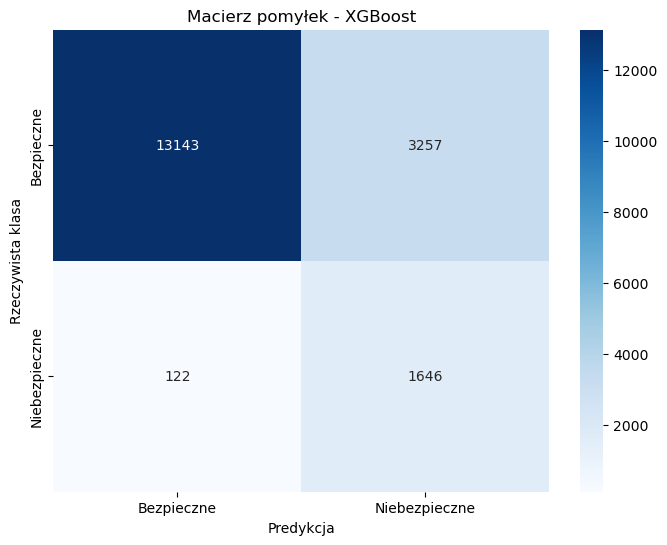

In [76]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bezpieczne', 'Niebezpieczne'],
            yticklabels=['Bezpieczne', 'Niebezpieczne'])
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista klasa')
plt.title('Macierz pomyłek - XGBoost')
plt.show()

In [ ]:
#top 10 niebezpieicznych asteroid

In [78]:
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
    x_scaled, y, df.index, test_size=0.2, stratify=y, random_state=42
)

In [79]:
df_test = df.loc[idx_test].copy()
df_test['proba_hazardous'] = xgb_model.predict_proba(x_test)[:, 1]
df_test['pred_label'] = y_pred_xgb

In [83]:
top10 = df_test.sort_values('proba_hazardous', ascending=False).head(10)
print("\nTOP 10 naj niebezpiecznych asteroid wg xgboost:")
print(top10[['id', 'name', 'proba_hazardous', 'pred_label', 'hazardous']])


TOP 10 naj niebezpiecznych asteroid wg xgboost:
             id                     name  proba_hazardous  pred_label  \
3114    3114014               (2002 CY9)         0.999976           1   
7655    2352102       352102 (2007 AG12)         0.999948           1   
28463   2363067      363067 (2000 CO101)         0.999941           1   
33212   3550889              (2010 SC41)         0.999941           1   
32768   2503941       503941 (2003 UV11)         0.999937           1   
90297   2418135       418135 (2008 AG33)         0.999931           1   
28751   2068216        68216 (2001 CV26)         0.999928           1   
1137    2066391  66391 Moshup (1999 KW4)         0.999922           1   
41577   2531899       531899 (2013 BE19)         0.999921           1   
84285  54106739               (2021 AF8)         0.999920           1   

       hazardous  
3114        True  
7655        True  
28463       True  
33212       True  
32768       True  
90297       True  
28751       Tr

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\bozen\AppData\Local\Temp\ipykernel_13760\1315843584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='name', y='proba_hazardous', palette='Reds_r')


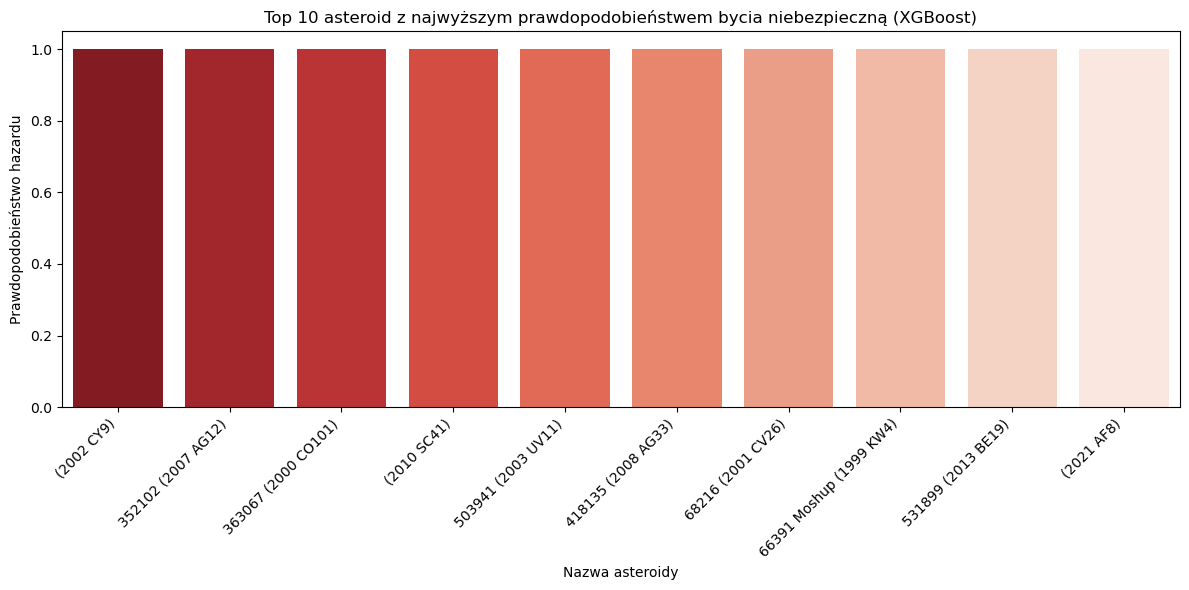

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=top10, x='name', y='proba_hazardous', palette='Reds_r')
plt.title('Top 10 asteroid, które mogą być niebezpieczne wg xgboost')
plt.xlabel('Nazwa asteroidy')
plt.ylabel('Prawdopodobieństwo hazardu')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# wnioski koncowe

# jesli celem jest wykrywanie zagrozen dla Ziemi, to xgboost bedzie najlepszy- ma najwyzszy recall sposrod modeli, 
# jednak niska precyzje, ale za to prawie zadna grozna asteroida nie zostanie przeoczona